
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EffiSciencesResearch/hackathon42/blob/main/starting_pack_hackathon42.ipynb)


In [2]:
# This can take a moment
# Please install git large file system before cloning
!git lfs install
!git clone https://github.com/EffiSciencesResearch/hackathon42.git

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
fatal: destination path 'hackathon42' already exists and is not an empty directory.


In [90]:
%cd /content/hackathon42

import numpy as np
from tqdm.notebook import tqdm
import os
from os.path import join
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

datasets_names = sorted(os.listdir(path='datasets'), key=lambda name: int(name[:2]))
datasets_names = {int(datasets_name.split("_")[0]): datasets_name for datasets_name in datasets_names}
print(datasets_names)

# You can choose the dataset here by modifying the brackets
dataset_name = join('datasets', datasets_names[1])
assert "01_mnist_cc" in dataset_name, "This colab is destined for MNIST, and not for the other datasets. The code needs to be adapted :) "
print(dataset_name)

X_labeled = np.load(join(dataset_name, "X_labeled.npy"))
y_labeled = np.load(join(dataset_name, "y_labeled.npy"))
X_unlabeled = np.load(join(dataset_name, "X_unlabeled.npy"))
X_val = np.load(join(dataset_name, "X_val.npy"))


X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled)


X_train = torch.tensor(X_train[:, :,:,:28], device=device).float()
X_test_tmp = torch.tensor(X_test, device=device).float()
X_test = torch.tensor(X_test[:, :,:,:28], device=device).float()
y_train = torch.tensor(y_train, device=device)
y_test = torch.tensor(y_test, device=device)

/content/hackathon42
{0: '00_toy_dataset', 1: '01_mnist_cc', 2: '02_mnist_constant_image', 3: '03_mnist_constant_image_random_row', 4: '04_mnist_uniform_color_random_row', 5: '05_mnist_uniform_color_low_mix_rate', 6: '06_mnist_sum', 8: '08_mnist_sum_noise_level', 12: '12_mnist_mysterious', 13: '13_mnist_mysterious', 23: '23_mnist_embed', 456: '456_mnist_embed', 888: '888_vehicle_animal', 999: '999_humans'}
datasets/01_mnist_cc


In [65]:
#@title Default title text
class LeNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()       
        
        # Could also be done with nn.sequential
        #self.conv1 = nn.Conv2d(1, 16, 5)
        #self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*2*11, 100)
        self.fc2 = nn.Linear(100, n_classes)
        self.flat = nn.Flatten()
        
    def forward(self, x):
        
        # Max pooling over a (2, 2) window
        #out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        #out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = self.flat(x)
        out = F.relu(self.fc1(out))
        x = F.dropout(x, training=self.training)
        pred = self.fc2(out)
        
        return pred

net = LeNet().float()
print(net)

LeNet(
  (fc1): Linear(in_features=704, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)


In [73]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
net = NeuralNetwork().to(device)
print(net)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=2, bias=True)
  )
)


In [74]:
import pandas as pd

tbatch = 100
nb_epochs = 20
nbbatchs = int(X_train.shape[0]/tbatch)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

net.train()

def evaluate(X_test):
    net.eval()
    with torch.no_grad():
        y_pred = net(X_test)
    correct_test = (torch.argmax(y_pred, axis=1) == y_test).sum().item()
    net.train()
    return correct_test/len(X_test)

for epoch in tqdm(range(nb_epochs)):  # loop over the dataset multiple times
    correct = 0
    for i in (range(nbbatchs)):
        
        optimizer.zero_grad()
        
        X_batch = X_train[i*tbatch:(i+1)*tbatch]
        y_batch = y_train[i*tbatch:(i+1)*tbatch]

        # Compute forward / backward
        y_pred = net(X_batch)
        correct += (torch.argmax(y_pred, axis=1) == y_batch).sum().item()

        loss = criterion(y_pred, y_batch)
        

        loss.backward()
        optimizer.step()
        # break
    print("acc train:", correct/X_train.shape[0], "acc test:", evaluate(X_test))


  0%|          | 0/20 [00:00<?, ?it/s]

acc train: 0.6926315789473684 acc test: 1.0
acc train: 0.9315789473684211 acc test: 0.9873817034700315
acc train: 0.9442105263157895 acc test: 1.0
acc train: 0.9452631578947368 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0


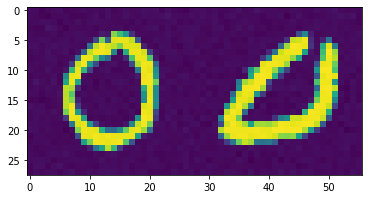

0 tensor(0)



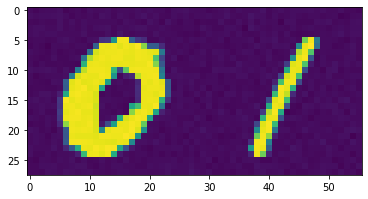

1 tensor(0)



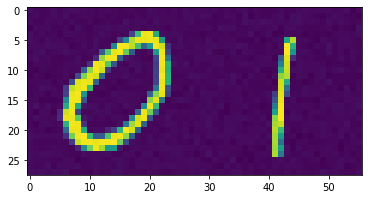

2 tensor(0)



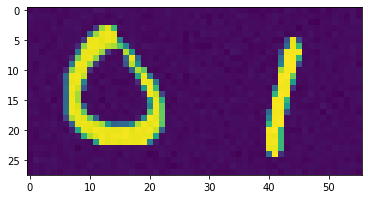

3 tensor(0)



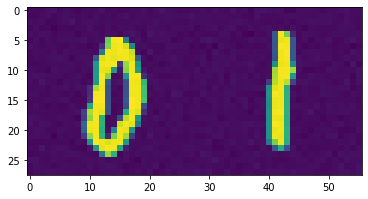

4 tensor(0)



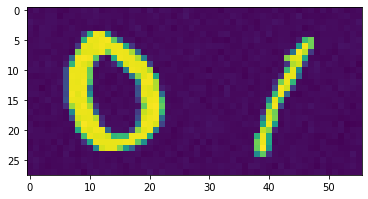

5 tensor(0)



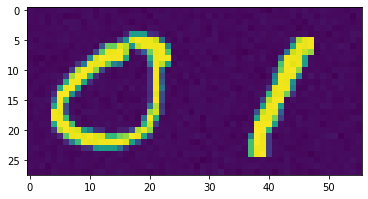

6 tensor(0)



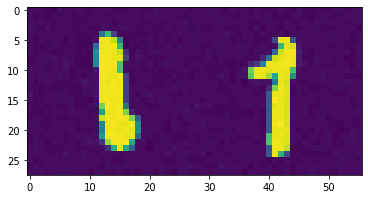

7 tensor(1)



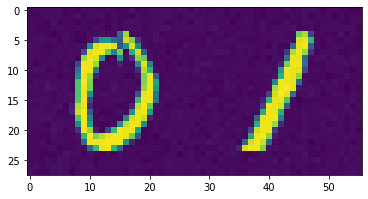

8 tensor(0)



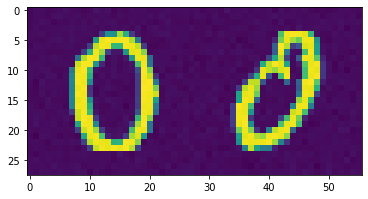

9 tensor(0)



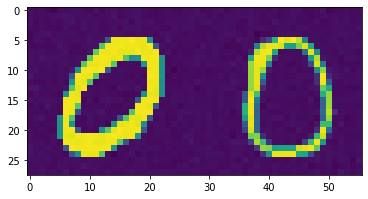

10 tensor(0)



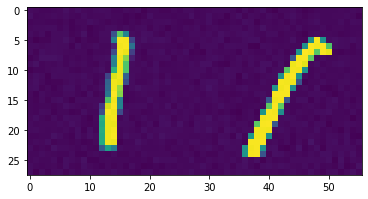

11 tensor(1)



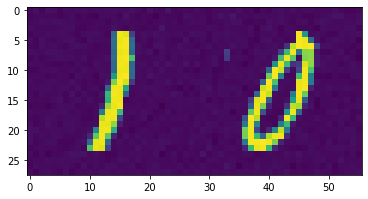

12 tensor(1)



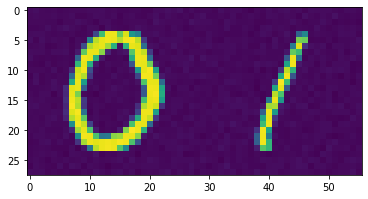

13 tensor(0)



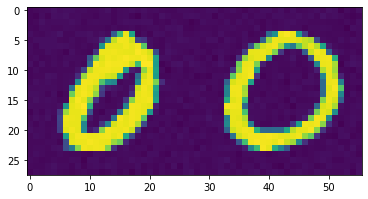

14 tensor(0)



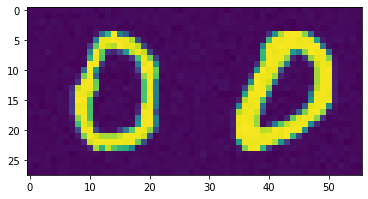

15 tensor(0)



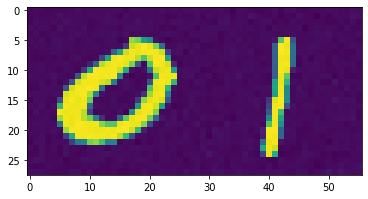

16 tensor(0)



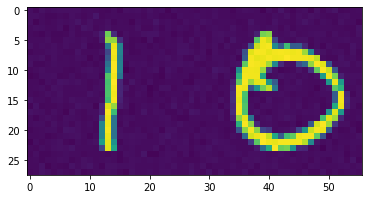

17 tensor(1)



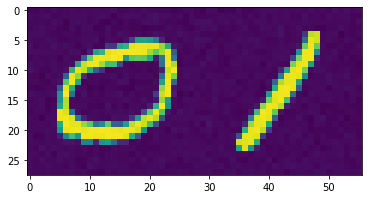

18 tensor(0)



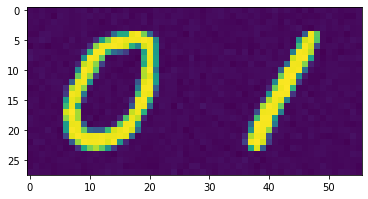

19 tensor(0)



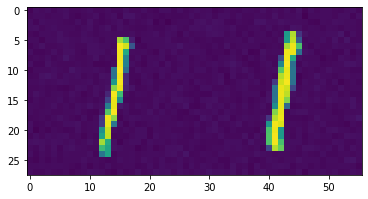

20 tensor(1)



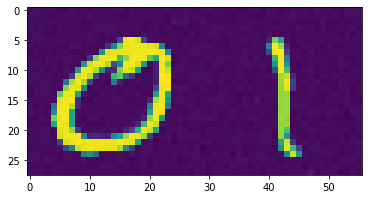

21 tensor(0)



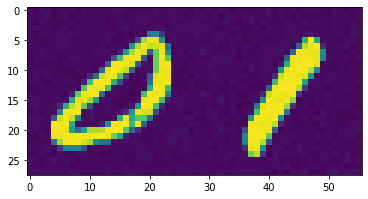

22 tensor(0)



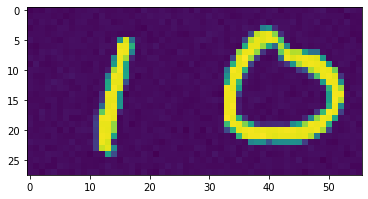

23 tensor(1)



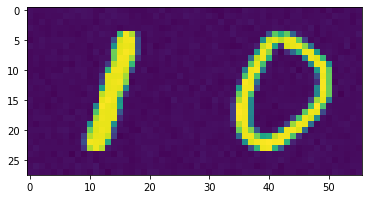

24 tensor(1)



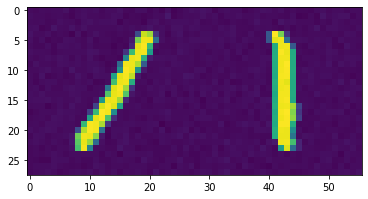

25 tensor(1)



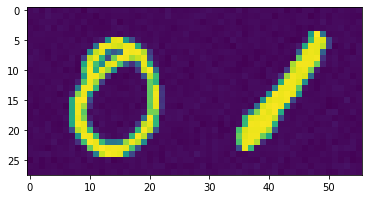

26 tensor(0)



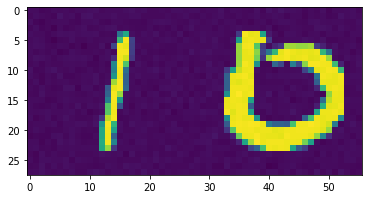

27 tensor(1)



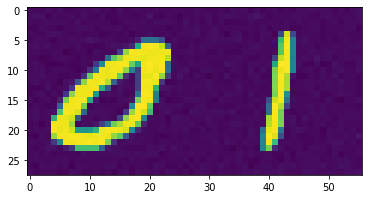

28 tensor(0)



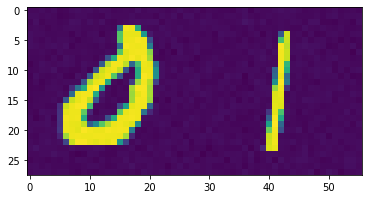

29 tensor(0)



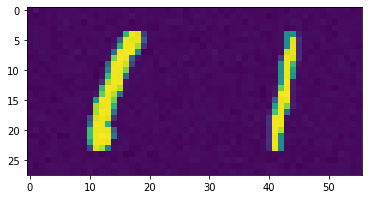

30 tensor(1)



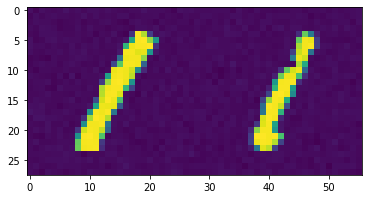

31 tensor(1)



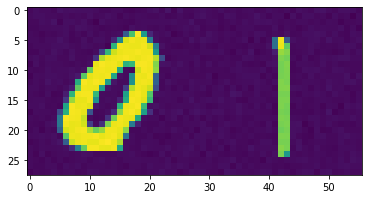

32 tensor(0)



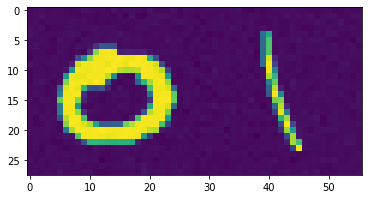

33 tensor(0)



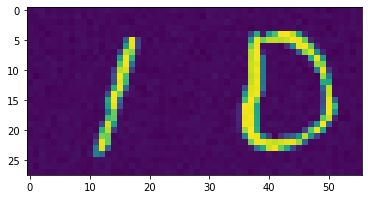

34 tensor(1)



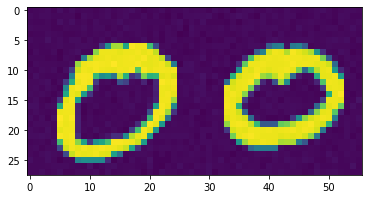

35 tensor(0)



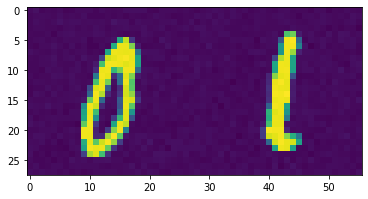

36 tensor(0)



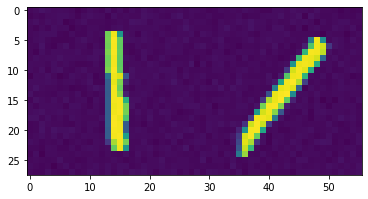

37 tensor(1)



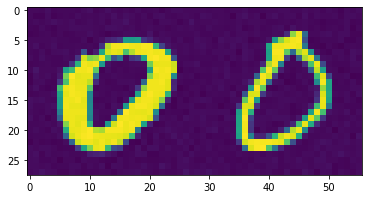

38 tensor(0)



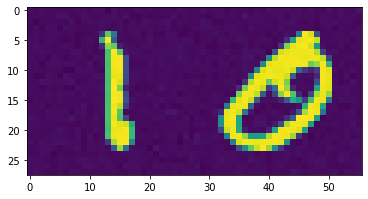

39 tensor(1)



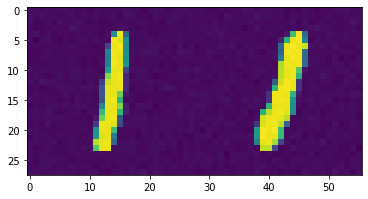

40 tensor(1)



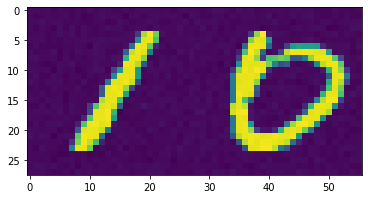

41 tensor(1)



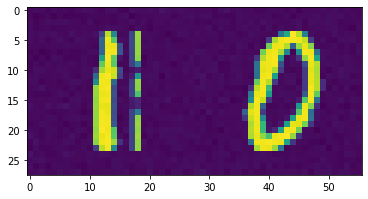

42 tensor(1)



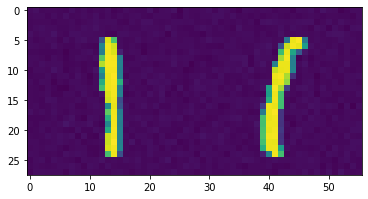

43 tensor(1)



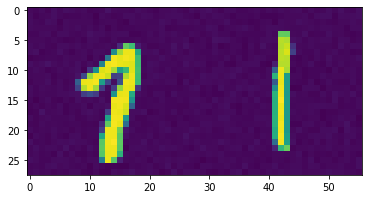

44 tensor(1)



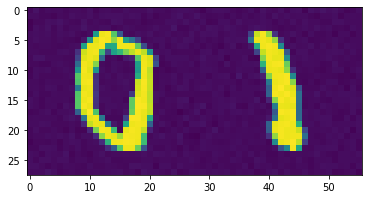

45 tensor(0)



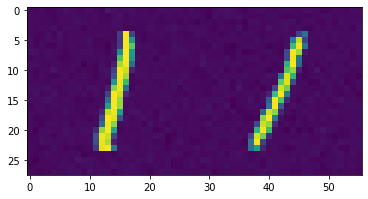

46 tensor(1)



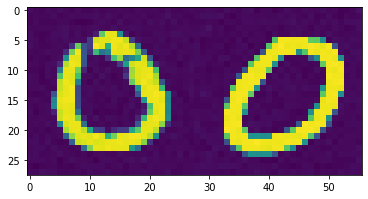

47 tensor(0)



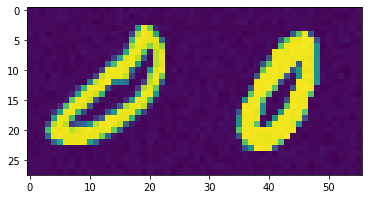

48 tensor(0)



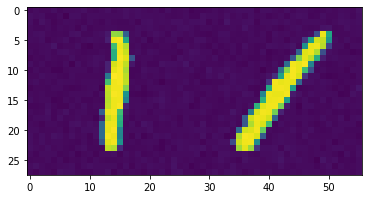

49 tensor(1)



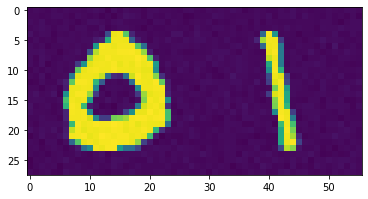

50 tensor(0)



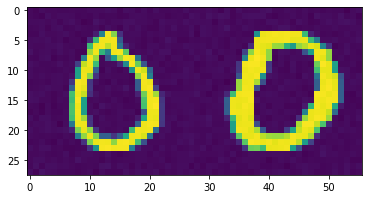

51 tensor(0)



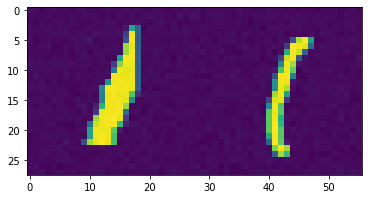

52 tensor(1)



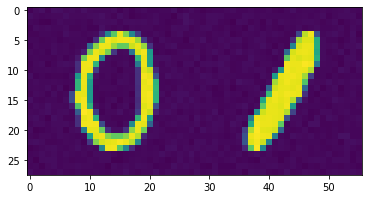

53 tensor(0)



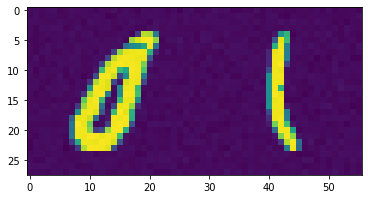

54 tensor(0)



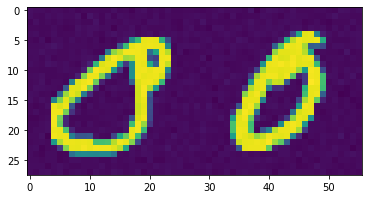

55 tensor(0)



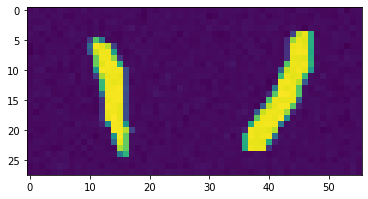

56 tensor(1)



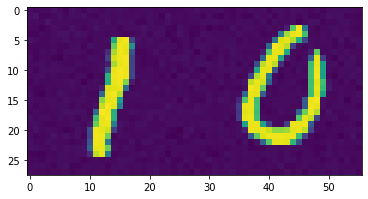

57 tensor(1)



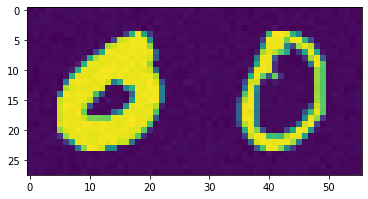

58 tensor(0)



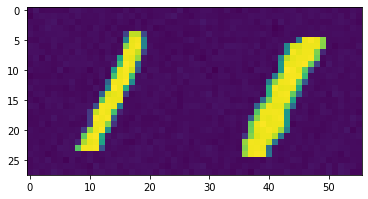

59 tensor(1)



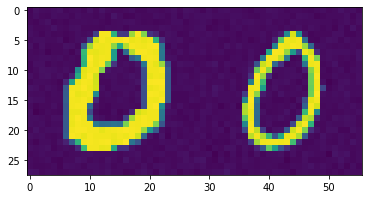

60 tensor(0)



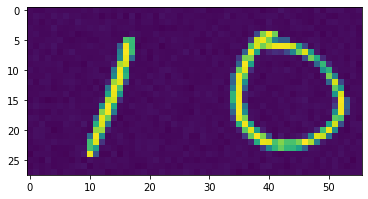

61 tensor(1)



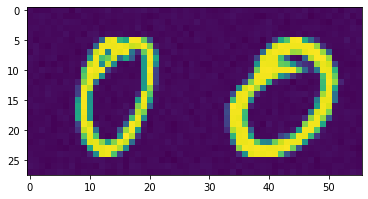

62 tensor(0)



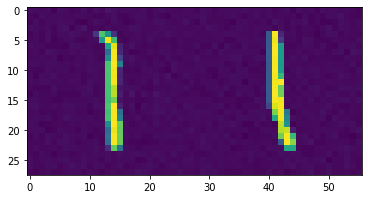

63 tensor(1)



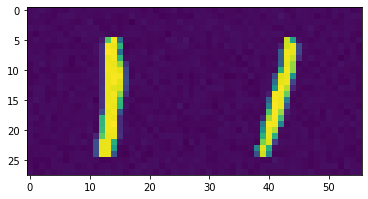

64 tensor(1)



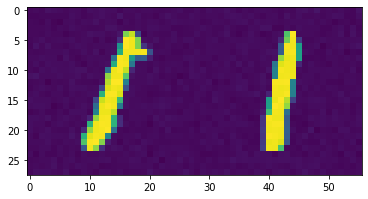

65 tensor(1)



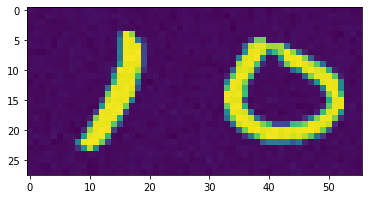

66 tensor(1)



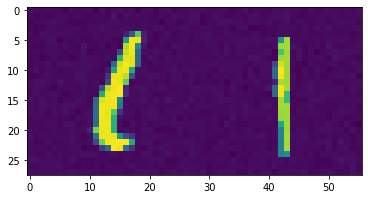

67 tensor(1)



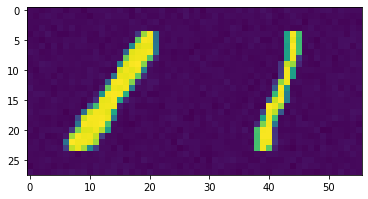

68 tensor(1)



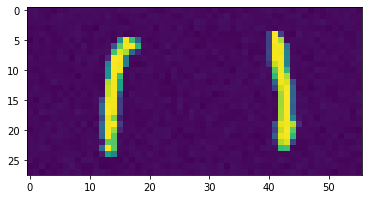

69 tensor(1)



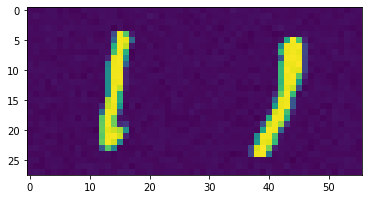

70 tensor(1)



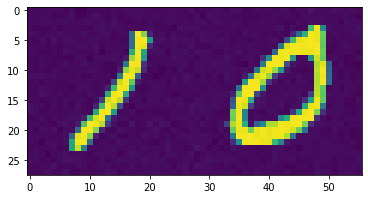

71 tensor(1)



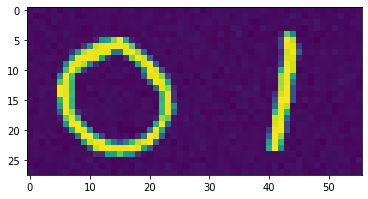

72 tensor(0)



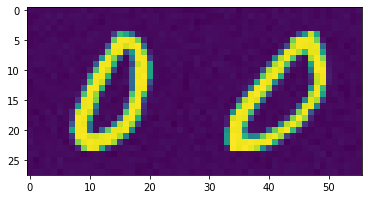

73 tensor(0)



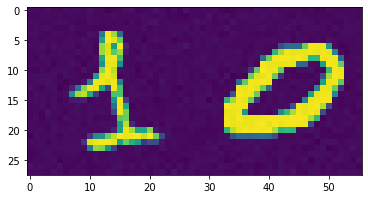

74 tensor(1)



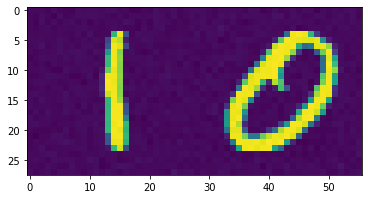

75 tensor(1)



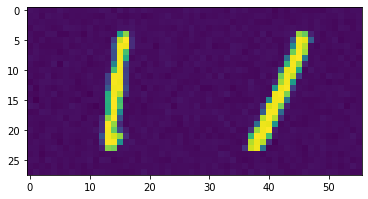

76 tensor(1)



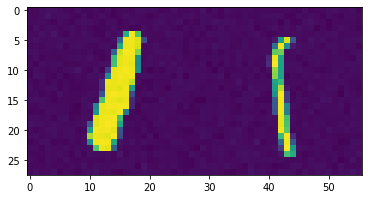

77 tensor(1)



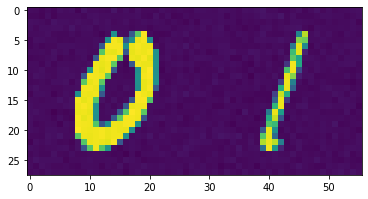

78 tensor(0)



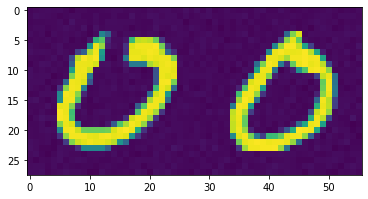

79 tensor(0)



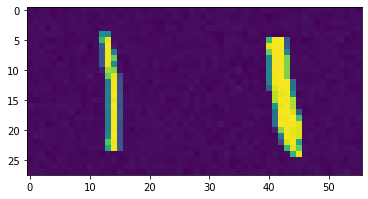

80 tensor(1)



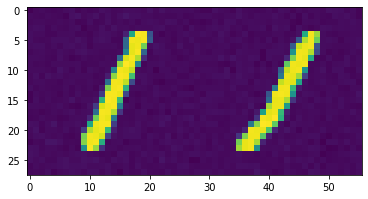

81 tensor(1)



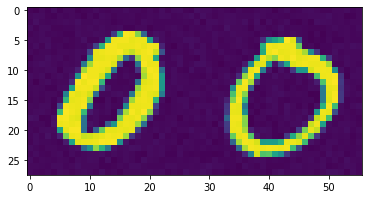

82 tensor(0)



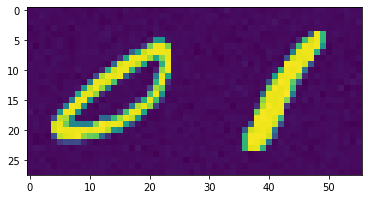

83 tensor(0)



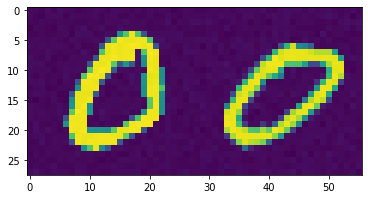

84 tensor(0)



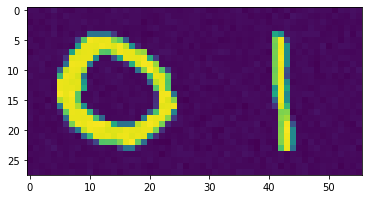

85 tensor(0)



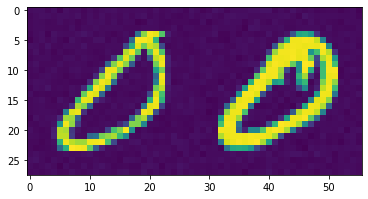

86 tensor(0)



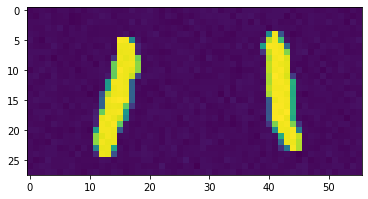

87 tensor(1)



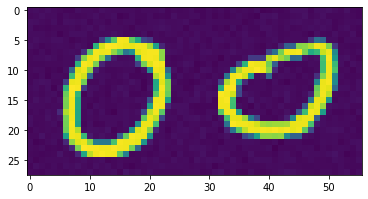

88 tensor(0)



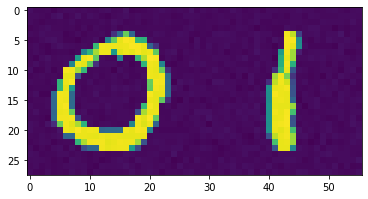

89 tensor(0)



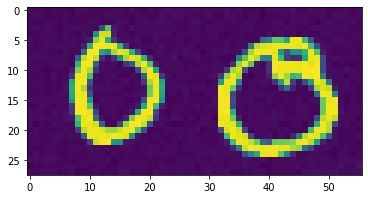

90 tensor(0)



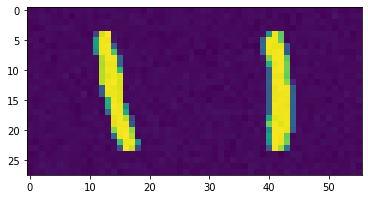

91 tensor(1)



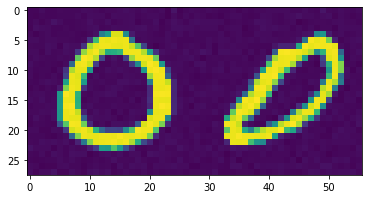

92 tensor(0)



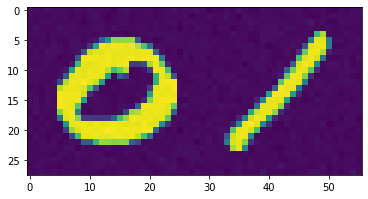

93 tensor(0)



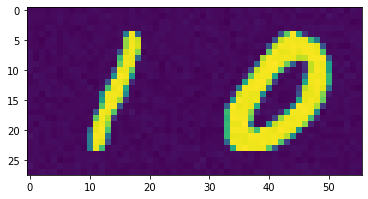

94 tensor(1)



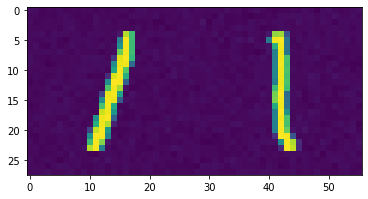

95 tensor(1)



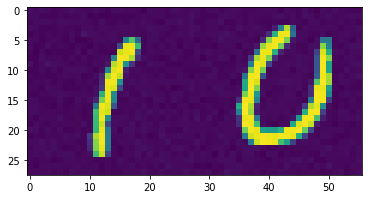

96 tensor(1)



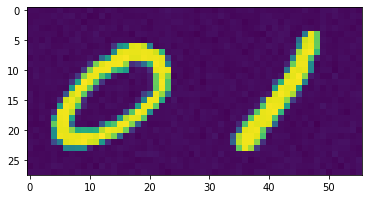

97 tensor(0)



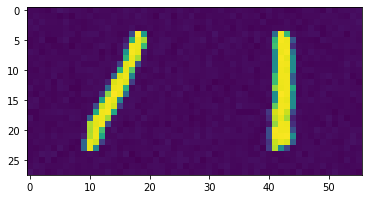

98 tensor(1)



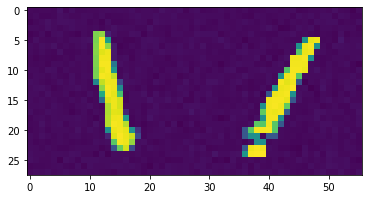

99 tensor(1)



In [94]:
import matplotlib.pyplot as plt

X_show = torch.tensor(X_val[:, :,:,:28], device=device).float()
X_show_tmp = torch.tensor(X_val, device=device).float()

y_show = torch.argmax(net(X_show), axis=1)

y_pred = net(X_batch)
correct += (torch.argmax(y_pred, axis=1) == y_batch).sum().item()

for i in range(100):
    plt.imshow(X_show_tmp[i, 0,:])
    plt.show()
    print(i, y_show[i])
    print("")

In [37]:
#@title
net.train()
with torch.no_grad():
    y_pred = net(X_test)


print(y_pred.shape)
pred = torch.argmax(y_pred, dim=1)

pred = pred.numpy()
df = pd.DataFrame(pred)
df.to_csv("example_submission.csv", header=False, index=False)

torch.Size([317, 10])
